# 03 - Inventory Optimization

This notebook demonstrates the **Optimizer** module for inventory management using reorder point policy.

## What we'll do:
1. Load forecasts from previous stage
2. Calculate safety stock and reorder points
3. Simulate inventory over time
4. Visualize inventory levels and orders
5. Save inventory plan for routing

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optimizer.optimizer import Optimizer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful!")

✅ Imports successful!


## 1. Load Forecasts from Previous Stage

In [2]:
# Load forecasts
forecasts = pd.read_csv('../output/02_forecasts.csv')
forecasts['date'] = pd.to_datetime(forecasts['date'])

print(f"📊 Loaded {len(forecasts)} forecast records")
print(f"📅 Date range: {forecasts['date'].min()} to {forecasts['date'].max()}")
print(f"\nForecast preview:")
forecasts.head()

📊 Loaded 336 forecast records
📅 Date range: 2024-01-07 00:00:00 to 2025-01-26 00:00:00

Forecast preview:


,store,product,date,sales,sample,prediction
0,A,A,2024-01-07,116.0,train,NaN
1,A,A,2024-01-14,140.0,train,NaN
2,A,A,2024-01-21,123.0,train,NaN
3,A,A,2024-01-28,128.0,train,NaN
4,A,A,2024-02-04,156.0,train,NaN


## 2. Initialize Optimizer

Configure inventory policy parameters:
- **Service Level**: 95% (probability of not stocking out)
- **Lead Time**: 2 weeks (time from order to delivery)
- **Planning Horizon**: 8 weeks

In [3]:
# Initialize optimizer
optimizer = Optimizer(
    primary_keys=['store', 'product'],
    date_col='date',
    target_col='sales',
    inv_col='inventory',
    planning_horizon=8,
    service_level=0.95,
    review_period=1,
    lead_time=2
)

print("✅ Optimizer initialized")
print(f"   Service Level: {optimizer.service_level * 100}%")
print(f"   Lead Time: {optimizer.lead_time} weeks")
print(f"   Planning Horizon: {optimizer.planning_horizon} weeks")

✅ Optimizer initialized
   Service Level: 95.0%
   Lead Time: 2 weeks
   Planning Horizon: 8 weeks


## 3. Run Inventory Simulation

In [4]:
# Simulate inventory
print("🔄 Running inventory simulation...\n")
inventory_plan = optimizer.simulate(forecasts)

print("✅ Simulation complete!")
print(f"\n📊 Inventory plan: {len(inventory_plan)} records")
print(f"\nColumns: {list(inventory_plan.columns)}")
print(f"\nSample inventory plan:")
inventory_plan[inventory_plan['sample'] == 'test'].head(10)

🔄 Running inventory simulation...

✅ Simulation complete!

📊 Inventory plan: 336 records

Columns: ['store', 'product', 'date', 'sales', 'sample', 'prediction', 'safety_stock', 'reorder_point', 'inventory', 'order', 'shipment']

Sample inventory plan:


,store,product,date,sales,sample,prediction,safety_stock,reorder_point,inventory,order,shipment
52,A,A,2025-01-05,NaN,test,189.534777,76.789358,380.520127,571.505477,0.000000,0.0
53,A,A,2025-01-12,NaN,test,179.465253,76.789358,380.520127,392.040225,0.000000,0.0
54,A,A,2025-01-19,NaN,test,176.851016,76.789358,380.520127,215.189208,165.330919,0.0
55,A,A,2025-01-26,NaN,test,176.374817,76.789358,380.520127,38.814391,341.705736,0.0
108,A,B,2025-01-05,NaN,test,142.128892,40.053912,350.938527,559.748163,0.000000,0.0
109,A,B,2025-01-12,NaN,test,139.807898,40.053912,350.938527,419.940265,0.000000,0.0
110,A,B,2025-01-19,NaN,test,150.729977,40.053912,350.938527,269.210287,81.728240,0.0
111,A,B,2025-01-26,NaN,test,151.599391,40.053912,350.938527,117.610896,233.327631,0.0
164,B,A,2025-01-05,NaN,test,232.512935,67.316384,542.008692,851.504448,0.000000,0.0
165,B,A,2025-01-12,NaN,test,232.512935,67.316384,542.008692,618.991513,0.000000,0.0


## 4. Analyze Inventory Metrics

In [5]:
# Focus on test period
test_inventory = inventory_plan[inventory_plan['sample'] == 'test'].copy()

print("📊 Inventory Metrics (Test Period):")
print(f"\n   Average Inventory: {test_inventory['inventory'].mean():.2f} units")
print(f"   Min Inventory: {test_inventory['inventory'].min():.2f} units")
print(f"   Max Inventory: {test_inventory['inventory'].max():.2f} units")
print(f"\n   Total Orders: {test_inventory['order'].sum():.2f} units")
print(f"   Total Shipments: {test_inventory['shipment'].sum():.2f} units")
print(f"\n   Stockouts: {(test_inventory['inventory'] < 0).sum()} periods")

# Summary by store-product
print("\n📈 Metrics by Store-Product:")
summary = test_inventory.groupby(['store', 'product']).agg({
    'inventory': 'mean',
    'order': 'sum',
    'safety_stock': 'first',
    'reorder_point': 'first'
}).round(2)
summary.columns = ['Avg Inventory', 'Total Orders', 'Safety Stock', 'Reorder Point']
print(summary)

📊 Inventory Metrics (Test Period):

   Average Inventory: 317.86 units
   Min Inventory: -15.31 units
   Max Inventory: 851.50 units

   Total Orders: 2729.58 units
   Total Shipments: 0.00 units

   Stockouts: 2 periods

📈 Metrics by Store-Product:
               Avg Inventory  Total Orders  Safety Stock  Reorder Point
store product                                                          
A     A               304.39        507.04         76.79         380.52
      B               341.63        315.06         40.05         350.94
B     A               502.74        543.57         67.32         542.01
      B               202.09        434.87         79.51         275.97
C     A               193.44        382.83         67.55         254.85
      B               362.89        546.22         76.69         436.88


## 5. Visualize Inventory Dynamics

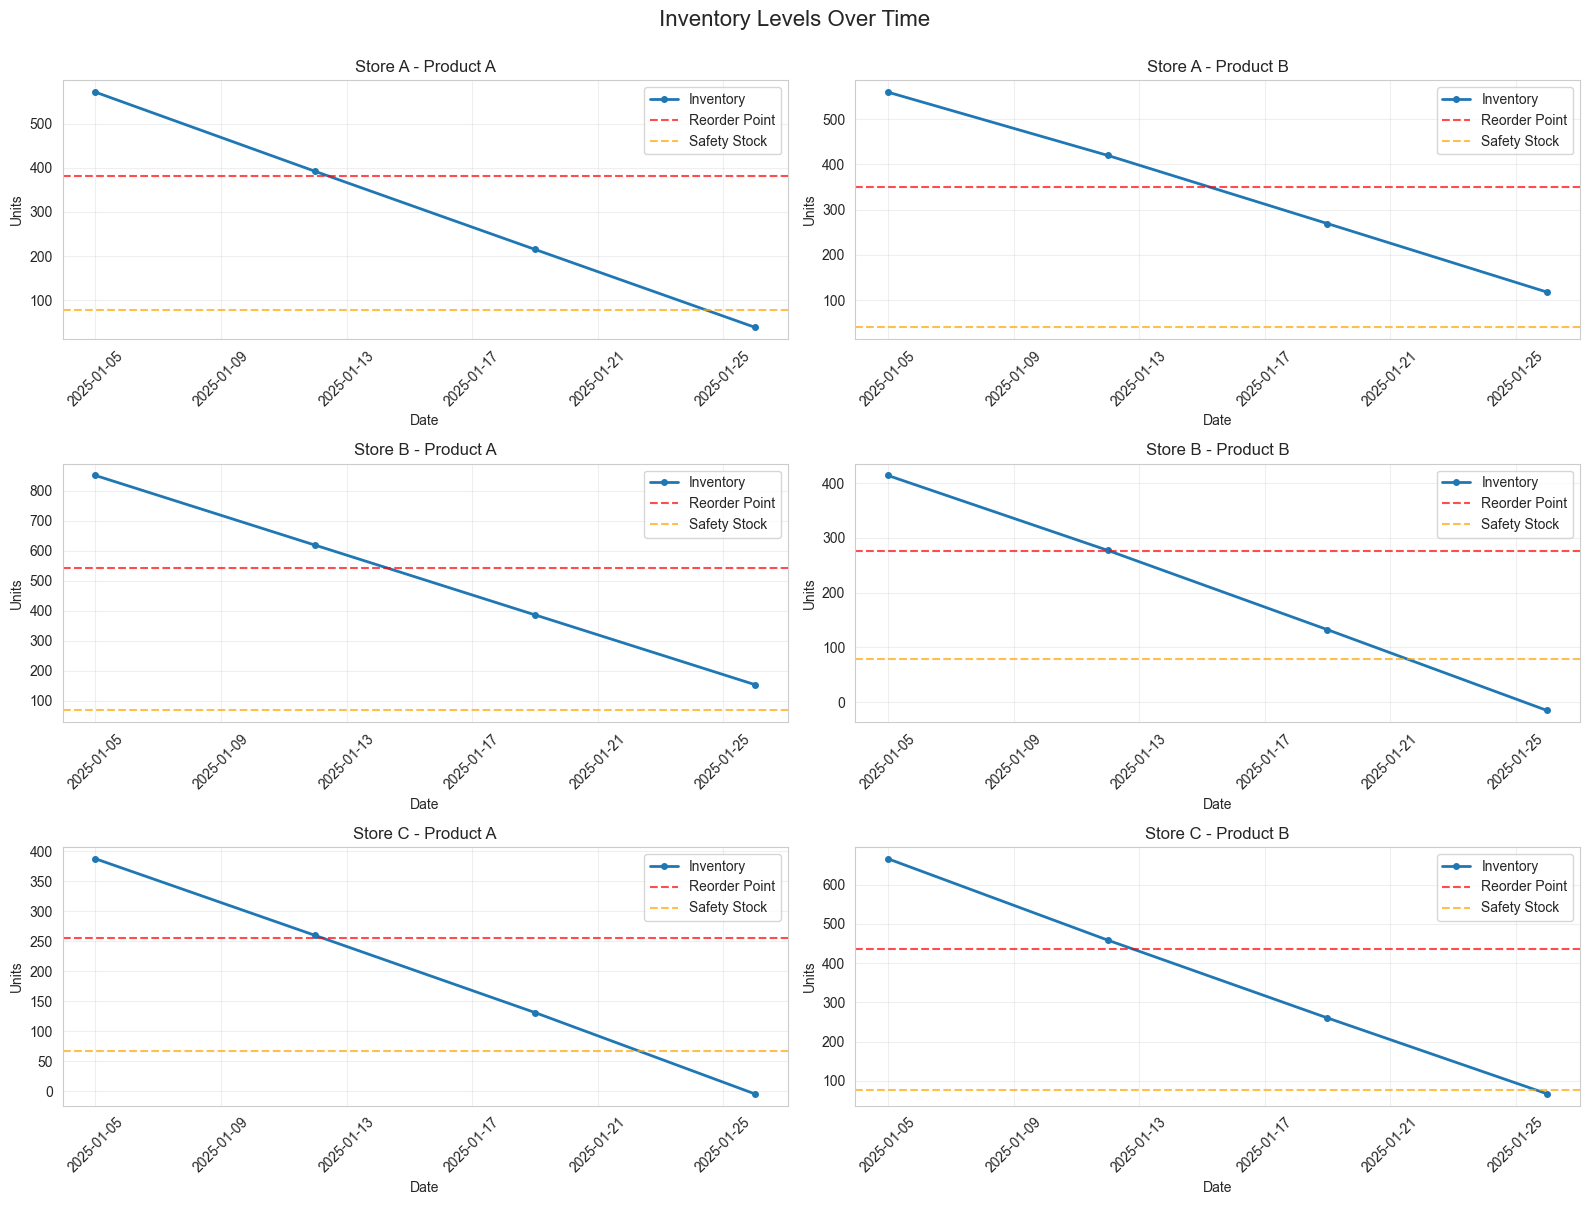

In [6]:
# Plot inventory levels over time
stores = sorted(test_inventory['store'].unique())
products = sorted(test_inventory['product'].unique())

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Inventory Levels Over Time', fontsize=16, y=1.00)

for i, store in enumerate(stores):
    for j, product in enumerate(products):
        ax = axes[i, j]
        subset = test_inventory[(test_inventory['store'] == store) & (test_inventory['product'] == product)]
        
        # Inventory level
        ax.plot(subset['date'], subset['inventory'], 'o-', label='Inventory', linewidth=2, markersize=4)
        
        # Reorder point
        ax.axhline(subset['reorder_point'].iloc[0], color='red', linestyle='--', label='Reorder Point', alpha=0.7)
        
        # Safety stock
        ax.axhline(subset['safety_stock'].iloc[0], color='orange', linestyle='--', label='Safety Stock', alpha=0.7)
        
        ax.set_title(f'Store {store} - Product {product}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Units')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

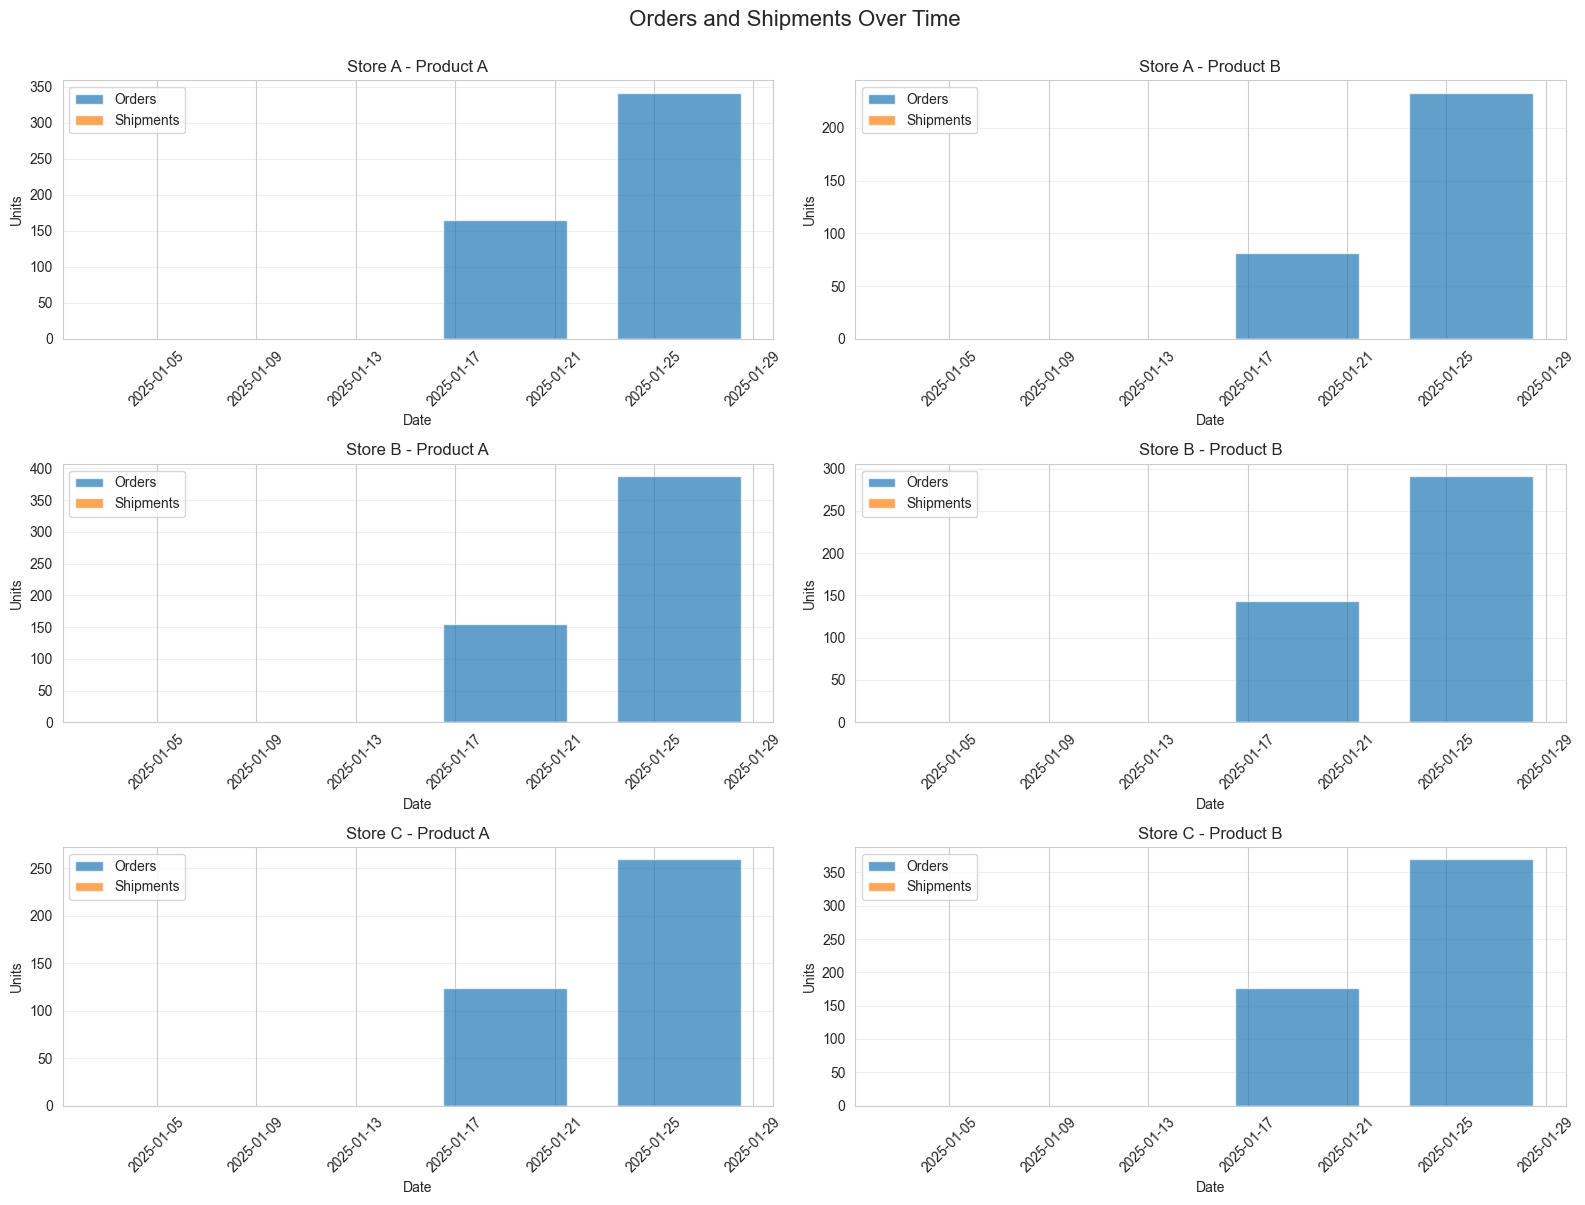

In [7]:
# Plot orders and shipments
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Orders and Shipments Over Time', fontsize=16, y=1.00)

for i, store in enumerate(stores):
    for j, product in enumerate(products):
        ax = axes[i, j]
        subset = test_inventory[(test_inventory['store'] == store) & (test_inventory['product'] == product)]
        
        # Orders
        ax.bar(subset['date'], subset['order'], alpha=0.7, label='Orders', width=5)
        
        # Shipments
        ax.bar(subset['date'], subset['shipment'], alpha=0.7, label='Shipments', width=5)
        
        ax.set_title(f'Store {store} - Product {product}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Units')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Analyze Order Patterns

In [8]:
# When do orders occur?
orders_placed = test_inventory[test_inventory['order'] > 0].copy()

print(f"📦 Order Analysis:")
print(f"\n   Total orders placed: {len(orders_placed)}")
print(f"   Average order size: {orders_placed['order'].mean():.2f} units")
print(f"   Max order size: {orders_placed['order'].max():.2f} units")

if len(orders_placed) > 0:
    print(f"\n📅 Orders by Store-Product:")
    order_summary = orders_placed.groupby(['store', 'product']).agg({
        'order': ['count', 'sum', 'mean']
    }).round(2)
    order_summary.columns = ['# Orders', 'Total Qty', 'Avg Qty']
    print(order_summary)

📦 Order Analysis:

   Total orders placed: 12
   Average order size: 227.46 units
   Max order size: 388.04 units

📅 Orders by Store-Product:
               # Orders  Total Qty  Avg Qty
store product                              
A     A               2     507.04   253.52
      B               2     315.06   157.53
B     A               2     543.57   271.79
      B               2     434.87   217.43
C     A               2     382.83   191.41
      B               2     546.22   273.11


## 7. Save Inventory Plan for Next Stage

In [9]:
# Save inventory plan
output_path = '../output/03_inventory_plan.csv'
inventory_plan.to_csv(output_path, index=False)

print(f"✅ Inventory plan saved to: {output_path}")
print(f"📊 Total records: {len(inventory_plan)}")
print(f"   - Training: {len(inventory_plan[inventory_plan['sample'] == 'train'])}")
print(f"   - Testing: {len(inventory_plan[inventory_plan['sample'] == 'test'])}")

✅ Inventory plan saved to: ../output/03_inventory_plan.csv
📊 Total records: 336
   - Training: 312
   - Testing: 24


## Summary

✅ Loaded demand forecasts

✅ Calculated safety stock and reorder points

✅ Simulated inventory dynamics with orders and shipments

✅ Analyzed inventory metrics and order patterns

✅ Saved inventory plan for delivery routing

**Next:** Open `04_delivery_routing.ipynb` to optimize delivery routes!